# Volumetric searchlight hyperalignment, 3rd part

<br><br>
<font size="4">
Revisiting the simple volumetric hyperalignment validation procedures with a larger (8 subjects), better pre-processed dataset (with more motion- and other regressors, proper brainmasking, smaller fwhm for spatial smoothing). 
</font>
<br>

## 1. Basics: imports, loading data
<br>

In [1]:
from mvpa2.suite import *

/usr/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/usr/lib/python2.7/dist-packages/mvpa2/testing/tools.py:81: DeprecationWarning: Importing from numpy.testing.decorators is deprecated since numpy 1.15.0, import from numpy.testing instead.
  from numpy.testing.decorators import skipif
/usr/lib/python2.7/dist-packages/_pytest/fixtures.py:844: DeprecationWarning: The `convert` argument is deprecated in favor of `converter`.  It will be removed after 2019/01.
  params = attr.ib(convert=attr.converters.optional(tuple))
/usr/lib/python2.7/dist-packages/_pytest/fixtures.py:846: DeprecationWarning: The `convert` argument is deprecated in favor of `converter`.  It will be removed after 2019/01.
  ids = attr.ib(default=None, convert=_ensure_immutable_i

<font size="4">
(Sidenote: These warnings seem worrisome, but pymvpa is undergoing migration to python3, hopefully that will solve these looming crashes)
</font>

In [2]:
import numpy as np
import time
from matplotlib import pyplot
from nilearn import datasets
from nilearn import surface
from nilearn import plotting


/home/adamb/.local/lib/python2.7/site-packages/nilearn/__init__.py:73: DeprecationWarning: Python2 support is deprecated and will be removed in the next release. Consider switching to Python 3.6 or 3.7.
  _python_deprecation_warnings()


<br>
<font size="4">
<b>Loading the dataset:</b> 8 subjects' bold fmri timeseries from the audio listening and reading tasks.
</font>
<br><br>

In [3]:
folderPath = '/home/adamb/PycharmProjects/preproc/runs34_files/'
datasetName = 'hyperDataset.hdf5'
ds = h5load(folderPath+datasetName)

/home/adamb/.local/lib/python2.7/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


<br>
<font size="4">
We verify that all datasets have the same dimensions and normalize each time series
</font>
<br><br>

In [4]:
for data in range(len(ds)):
    print ds[data].shape
    c = np.ones([ds[data].shape[0],])
    ds[data].sa['chunks'] = c
    zscore(ds[data], chunks_attr='chunks')
    

(946, 67643)
(946, 67643)
(946, 67643)
(946, 67643)
(946, 67643)
(946, 67643)
(946, 67643)
(946, 67643)


## 2. Initial ISC (simple correlation) results 
<br>
<font size="4">
Before hyperalignment, we correlate each subject's data to the group mean formed by averaging the data from the rest of the subjects. If hyperalignment works as expected, by definition, these correlations should be stronger after hyperalignment.   
</font>
<br><br>

Results matrix is empty array of size (8, 67643)
Calculations for sub 0 took 5.50731897354 secs
Calculations for sub 1 took 5.52186203003 secs
Calculations for sub 2 took 5.37082791328 secs
Calculations for sub 3 took 5.65048193932 secs
Calculations for sub 4 took 5.469009161 secs
Calculations for sub 5 took 5.37247920036 secs
Calculations for sub 6 took 5.34806108475 secs
Calculations for sub 7 took 5.40627479553 secs


5242 voxels show a correlation coeff > 0.1
268 voxels show a correlation coeff > 0.2
8 voxels show a correlation coeff > 0.3


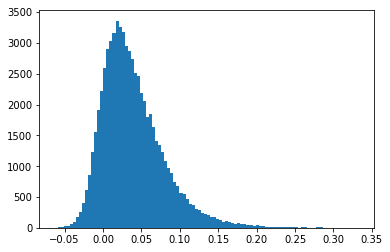

In [5]:
# no. of datasets we use here
dataNo = len(ds)
# dataset shape as list
dataShape = list(ds[0].shape)  # TRs X voxels (== samples X features in pymvpa lingo)

# result matrix for storing all correlation coeffs: subjects X voxels (==features)
corrRes = np.empty([dataNo, dataShape[1]])
print 'Results matrix is empty array of size ' + str(corrRes.shape)

# we extract the group data into one np array from the datasets so we can calculate with it more easily
# (this step feels unneccessary, but I always run into problems when 
# trying to calculate with the pymvpa dataset arrays directly - maybe later I'll figure it out)
groupData = np.empty([dataNo, dataShape[0], dataShape[1]])
for subIdx in range(dataNo):
    groupData[subIdx, :, :] = ds[subIdx].__array__()
    
# go through subjects, correlate with the rest of the group
for subIdx in range(dataNo):
    
    # indices for everyone except the main subject in the loop
    groupIndices = list(range(dataNo))
    del(groupIndices[subIdx])
    # mean data for everyone except our subject of interest
    groupMean = np.mean(groupData[groupIndices, :, :], 0)
    
    startTime = time.time()
    for voxel in range(dataShape[1]):
        # it is inefficient this way, should use stg like np.dot() with vector magnitude normalization
        # e.g. np.dot(a,b)/(np.sqrt(a.dot(a))*np.sqrt(b.dot(b))) ???
        corrRes[subIdx, voxel] = np.corrcoef(ds[subIdx].__array__()[:, voxel], groupMean[:, voxel], rowvar=False)[0, 1]
    finishTime = time.time()-startTime
    print 'Calculations for sub ' + str(subIdx) + ' took ' + str(finishTime) + ' secs'
    
# mean correlation map
meanCorr = np.mean(corrRes, 0)

# look at the overall spread of values
_ = pyplot.hist(meanCorr, 100)

# get a feel of the data
print '\n'
print str(sum(meanCorr>0.1)) + ' voxels show a correlation coeff > 0.1'
print str(sum(meanCorr>0.2)) + ' voxels show a correlation coeff > 0.2'
print str(sum(meanCorr>0.3)) + ' voxels show a correlation coeff > 0.3'

<br>
<font size="4">
<b>Looks nice, showing the expected widespread correlations. </b>

Now that we have the initial group-level correlation map, let's transform it back into a 3D nifti image and take a look. We use the built-in methods of pymvpa datasets, and substitute our correlation value array as imaging data array. For details look in this tutorial: http://www.pymvpa.org/tutorial_mappers.html     
</font>
<br><br>

In [6]:
# get image from the correlation coeff values 
corrImg = map2nifti(ds[0], meanCorr)
# stupid workaround again
corrImg.to_filename('initialCorrResults.nii')
corrImg = nb.load('initialCorrResults.nii')



<br>
<font size="4">
Now that we have a proper nifti image, there are countless ways to plot it. Here we project to the surface using nilearn, just to stay in the python universe:
</font>
<br><br>

<div class="alert alert-block alert-warning">
    <font size ="4">
    <b>This part can take a few minutes!</b>
    </font>
</div>

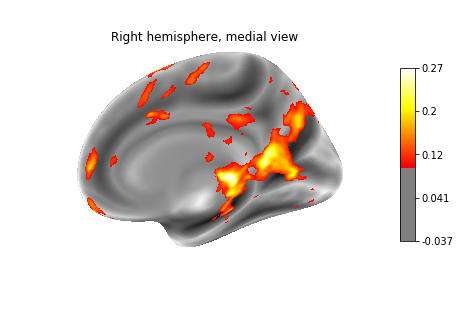

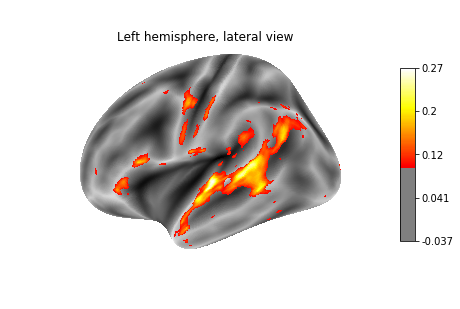

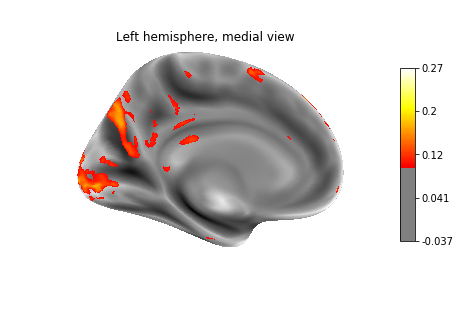

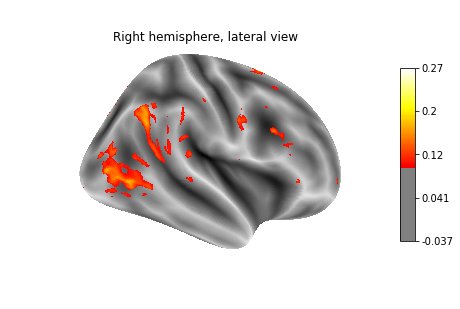

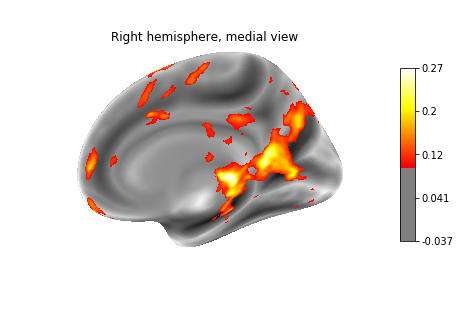

In [7]:
# visualization with nilearn
# thresholding the map at +0.10 as the minimum correlation we want to see

# load the fsaverage surface template
fsaverage = datasets.fetch_surf_fsaverage(mesh='fsaverage')
# create a texture from the volumetric data
texture = surface.vol_to_surf(corrImg,
                              fsaverage.pial_left,
                              interpolation='linear'
                              )
# 4 plots: left lateral and medial, right lateral and medial
plotting.plot_surf_stat_map(fsaverage.infl_left,
                            texture,
                            hemi='left',
                            threshold=0.10,
                            bg_map=fsaverage.sulc_left,
                            view='lateral',
                            symmetric_cbar=False,
                            title='Left hemisphere, lateral view'
                            )
plotting.plot_surf_stat_map(fsaverage.infl_left,
                            texture,
                            hemi='left',
                            threshold=0.10,
                            bg_map=fsaverage.sulc_left,
                            view='medial',
                            symmetric_cbar=False,
                            title='Left hemisphere, medial view'
                            )
plotting.plot_surf_stat_map(fsaverage.infl_right,
                            texture,
                            hemi='right',
                            threshold=0.10,
                            bg_map=fsaverage.sulc_right,
                            view='lateral',
                            symmetric_cbar=False,
                            title='Right hemisphere, lateral view'
                            )
plotting.plot_surf_stat_map(fsaverage.infl_right,
                            texture,
                            hemi='right',
                            threshold=0.10,
                            bg_map=fsaverage.sulc_right,
                            view='medial',
                            symmetric_cbar=False,
                            title='Right hemisphere, medial view'
                            )


<br>
<font size="4">


</font>
<br><br>

## 3. Searchlight hyperalignment - sanity check
<br>
<font size="4">
Now we can turn to hyperalignment itself. To make sure the procedure works as it should, we perform hyperalignment on all our data and then calculate the correlations with the group averages again. For the hyperalignment itself, we follow 
<a href="http://www.pymvpa.org/examples/hyperalignment.html#searchlight-hyperalignment">the corresponding tutorial at pyvmpa.org</a>

First, let's calculate the hyperaligment mappings into the common space for all subjects, using all the data we have.
</font>
<br><br>

<div class="alert alert-block alert-warning">
    <font size ="4">
    <b>This part can take a few minutes!</b>
    </font>
</div>

In [8]:
# we call SearchlightHyperalignment mostly with default values: 
# each sphere has a radius of 3 voxels, sphere centers are also 3 voxels apart, 
# all voxels in a given sphere are used for alignment
slhyper = SearchlightHyperalignment(radius=3, 
                                    sparse_radius=3, 
                                    nproc=1)

slhyperStart = time.time()
# call the hyperalignment object with the full dataset we have, 
# resulting mappers will be stored in slhypmaps
slhypermaps = slhyper(ds)
print '\nHyperalignment took ' + str(time.time()-slhyperStart) + ' secs'


 * Please note: warnings are printed only once, but underlying problem might occur many times *

Hyperalignment took 2028.71326709 secs


<br>
<font size ="4">
    
Let's save out the mappings and then verify that they are Pymvpa mapper objects.    
</font>
<br><br>

In [9]:
# save into hdf5, it is quite large
h5save('hyperMappings.hd5', slhypermaps)
print type(slhypermaps[0])

<class 'mvpa2.mappers.staticprojection.StaticProjectionMapper'>


<br>
<font size ="4">
Apply the mappers. The output will be the dataset projected into the common space.    
</font>
<br><br>

In [7]:
dsHyper = []
# loop through subjects
for subIdx in range(dataNo):
    startT = time.time()
    # the mapper supports both forward and reverse mappings as methods
    dsHyper.append(slhypermaps[subIdx].forward(ds[subIdx]))
    print 'Projection for subject ' + \
        str(subIdx) + ' took ' + str(time.time()-startT) + ' secs'


Projection for subject 0 took 10.0576760769 secs
Projection for subject 1 took 10.0538780689 secs
Projection for subject 2 took 10.154556036 secs
Projection for subject 3 took 10.2909209728 secs
Projection for subject 4 took 10.2489891052 secs
Projection for subject 5 took 10.0677778721 secs
Projection for subject 6 took 10.0695300102 secs
Projection for subject 7 took 10.0658788681 secs


In [12]:
# to avoid memory issues, save out the mappings and only keep what we need
h5save('datasetHyperaligned.hd5', dsHyper)
del ds
del slhypermaps

<br>
<font size ="4">
So far so good. Now we re-run the correlations with the hyperaligned data and plot the results. Fingers crossed!
</font>
<br><br>

<div class="alert alert-block alert-warning">
    <font size ="4">
    <b>These parts below can take a few minutes!</b>
    </font>
</div>

Results matrix for hyperalligned data is empty array of size (8, 67643)
Calculations for sub 0 took 4.20589184761 secs
Calculations for sub 1 took 4.30063796043 secs
Calculations for sub 2 took 4.20781493187 secs
Calculations for sub 3 took 4.29731988907 secs
Calculations for sub 4 took 4.18408513069 secs
Calculations for sub 5 took 4.26994013786 secs
Calculations for sub 6 took 4.1848449707 secs
Calculations for sub 7 took 4.28135490417 secs


67643 voxels show a correlation coeff > 0.1
67352 voxels show a correlation coeff > 0.2
40433 voxels show a correlation coeff > 0.3


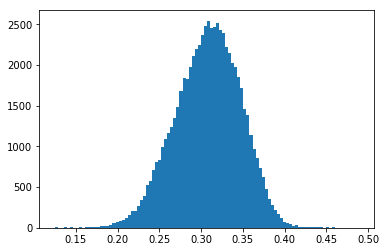

In [14]:

# result matrix for storing all correlation coeffs: subjects X voxels (==features)
corrResHyper = np.empty([dataNo, dataShape[1]])
print 'Results matrix for hyperalligned data is empty array of size ' + str(corrResHyper.shape)

# we extract the group data into one np array from the datasets so we can calculate with it more easily
# (this step feels unneccessary, but I always run into problems when 
# trying to calculate with the pymvpa dataset arrays directly - maybe later I'll figure it out)
groupData = np.empty([dataNo, dataShape[0], dataShape[1]])
for subIdx in range(dataNo):
    groupData[subIdx, :, :] = dsHyper[subIdx].__array__()
    
# go through subjects, correlate with the rest of the group
for subIdx in range(dataNo):
    
    # indices for everyone except the main subject in the loop
    groupIndices = list(range(dataNo))
    del(groupIndices[subIdx])
    # mean data for everyone except our subject of interest
    groupMean = np.mean(groupData[groupIndices, :, :], 0)
    
    startTime = time.time()
    for voxel in range(dataShape[1]):
        # it is inefficient this way, should use stg like np.dot() with vector magnitude normalization
        # e.g. np.dot(a,b)/(np.sqrt(a.dot(a))*np.sqrt(b.dot(b))) ???
        corrResHyper[subIdx, voxel] = np.corrcoef(dsHyper[subIdx].__array__()[:, voxel], groupMean[:, voxel], rowvar=False)[0, 1]
    finishTime = time.time()-startTime
    print 'Calculations for sub ' + str(subIdx) + ' took ' + str(finishTime) + ' secs'
    
# mean correlation map
meanCorrHyper = np.mean(corrResHyper, 0)

# look at the overall spread of values
_ = pyplot.hist(meanCorrHyper, 100)

# get a feel of the data
print '\n'
print str(sum(meanCorrHyper>0.1)) + ' voxels show a correlation coeff > 0.1'
print str(sum(meanCorrHyper>0.2)) + ' voxels show a correlation coeff > 0.2'
print str(sum(meanCorrHyper>0.3)) + ' voxels show a correlation coeff > 0.3'

In [15]:
# get image from the correlation coeff values 
corrImgHyper = map2nifti(dsHyper[0], meanCorrHyper)
# stupid workaround again
corrImgHyper.to_filename('hyperCorrResults.nii')
corrImgHyper = nb.load('hyperCorrResults.nii')


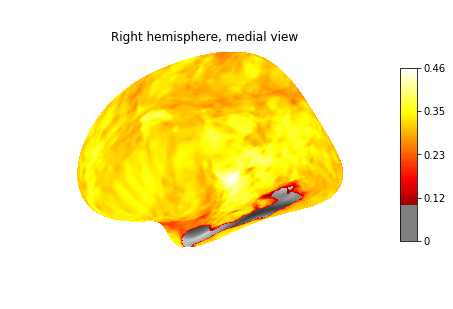

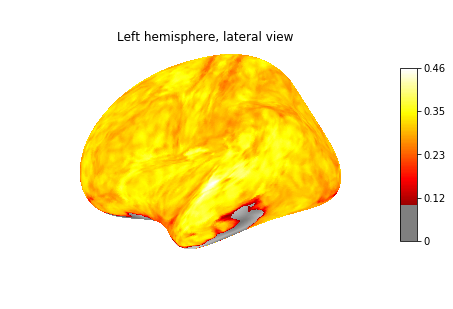

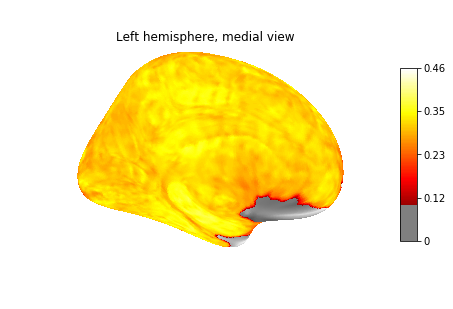

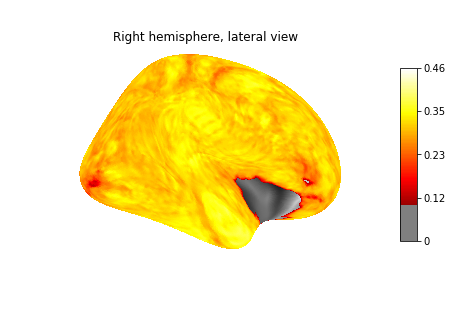

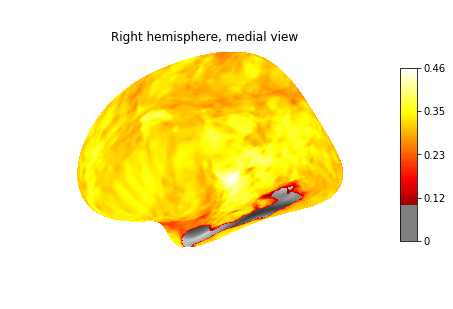

In [18]:
# visualization with nilearn again

# create a texture from the volumetric data
texture = surface.vol_to_surf(corrImgHyper,
                              fsaverage.pial_left,
                              interpolation='linear'
                              )
# 4 plots: left lateral and medial, right lateral and medial
plotting.plot_surf_stat_map(fsaverage.infl_left,
                            texture,
                            hemi='left',
                            threshold=0.10,
                            bg_map=fsaverage.sulc_left,
                            view='lateral',
                            symmetric_cbar=False,
                            title='Left hemisphere, lateral view'
                            )
plotting.plot_surf_stat_map(fsaverage.infl_left,
                            texture,
                            hemi='left',
                            threshold=0.10,
                            bg_map=fsaverage.sulc_left,
                            view='medial',
                            symmetric_cbar=False,
                            title='Left hemisphere, medial view'
                            )
plotting.plot_surf_stat_map(fsaverage.infl_right,
                            texture,
                            hemi='right',
                            threshold=0.10,
                            bg_map=fsaverage.sulc_right,
                            view='lateral',
                            symmetric_cbar=False,
                            title='Right hemisphere, lateral view'
                            )
plotting.plot_surf_stat_map(fsaverage.infl_right,
                            texture,
                            hemi='right',
                            threshold=0.10,
                            bg_map=fsaverage.sulc_right,
                            view='medial',
                            symmetric_cbar=False,
                            title='Right hemisphere, medial view'
                            )

<br>
<font size ="4">
<b>Sanity check passed with flying colors :)</b> 
Pymvpa hyperalignment works as advertised. As a next step we will use hyperalignment properly, deriving mappings from a part of the data and testing its effects in terms of ISC on held-out data. Stay tuned!
</font>
<br><br>